# Solution: Modelling population turnover

<img src="../../IDM1/Graphics and Data/w4_nb1_model_diagram.png">

The differential equations for an SIR model with population turnover look like this:

\begin{align}
\frac{dS}{dt} & = -\beta \frac{I}{N} S - \mu S + bN \\
\frac{dI}{dt} & = \beta \frac{I}{N} S - \gamma I - \mu I \\
\frac{dR}{dt} & = \gamma I - \mu R
\end{align}

This structure assumes that every individual in each compartment experiences the same background mortality $\mu$ (there is no additional mortality from the infection for example, and we make no distinction by age). Those who have died no longer contribute to infection (a sensible assumption for many diseases). Babies are all born at a rate *b* into the susceptible compartment. 

Note that, as always, we calculate the people dying in each of the compartments by multiplying the number in that compartment by the rate $\mu$. Even though babies are all born into the same compartment, the birth rate still depends on the population in all of the compartments, hence why we need to multiply *b* by the total population size *N*. In the following etivity, we choose a value of *b* to allow a constant population size, so that all deaths are balanced by births.

**Modelling an acute disease epidemic in a fully susceptible human population**

Parameters:  
$\beta$ = 0.4 days$^{-1}$ = 0.4 * 365 years$^{-1}$  
$\gamma$ = 0.2 days$^{-1}$ = 0.2 * 365 years$^{-1}$  
$\mu$ = 1/70 years$^{-1}$  
*b* = 1/70 years$^{-1}$  

In the example below, we are running the model for the 400 year period, but first only plotting the number of infected people only over the course of 1 year.

Warning message:
"package 'deSolve' was built under R version 3.6.1"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"Removed 72818 rows containing missing values (geom_path)."

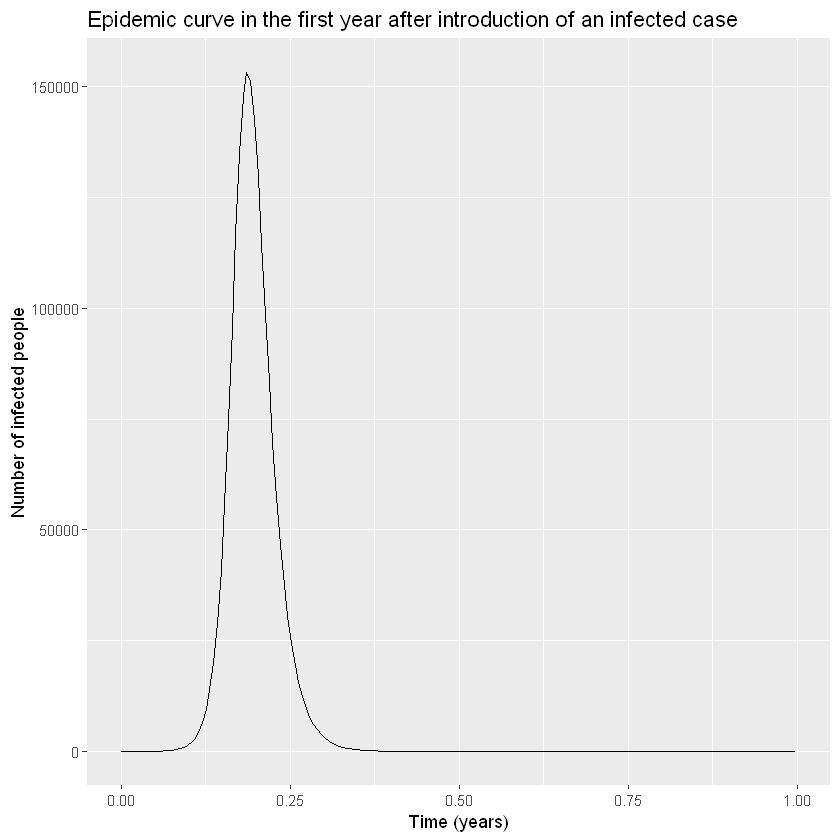

In [1]:
# LOAD THE PACKAGES:
library(deSolve)
library(reshape2)
library(ggplot2)

# MODEL INPUTS:

# Vector storing the initial number of people in each compartment (at timestep 0)
initial_state_values <- c(S = 1000000-1,   # the whole population we are modelling is susceptible to infection
                          I = 1,           # the epidemic starts with a single infected person
                          R = 0)           # there is no prior immunity in the population

# Vector storing the parameters describing the transition rates in units of years^-1
parameters <- c(beta = 0.4*365,      # the infection rate, which acts on susceptibles
                gamma = 0.2*365,     # the rate of recovery, which acts on those infected
                mu = 1/70,           # the background mortality rate, which acts on every compartment
                b = 1/70)            # the birth rate

# TIMESTEPS:

# Vector storing the sequence of timesteps to solve the model at
times <- seq(from = 0, to = 400, by = 2/365)   # from 0 to 400 YEARS in intervals of every 2 days

# SIR MODEL FUNCTION: 

# The model function takes as input arguments (in the following order): time, state and parameters
sir_model <- function(time, state, parameters) {  

    with(as.list(c(state, parameters)), {  # tell R to look for variable names within the state and parameters objects    
        
    # Calculating the total population size N (the sum of the number of people in each compartment)
      N <- S+I+R
      
    # Defining lambda as a function of beta and I:
      lambda <- beta * I/N
        
    # The differential equations with addition of births and deaths
      dS <- -lambda * S - mu * S + b * N            
      dI <- lambda * S - gamma * I  - mu * I           
      dR <- gamma * I - mu * R               
      
    # Return the number of people in the S, I and R compartments at each timestep 
    # (in the same order as the input state variables)
    return(list(c(dS, dI, dR))) 
    })
  
}

# MODEL OUTPUT (solving the differential equations):

# Solving the differential equations using the ode integration algorithm
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

# PLOT

# Plot of the epidemic curve for the first year
ggplot(data = output,                                               
       aes(x = time, y = I)) +                                           # only plotting the I column from our output dataframe
  geom_line() +                                                          # represent data as lines
  xlab("Time (years)")+                                                  # add label for x axis
  ylab("Number of infected people") +                                    # add label for y axis
  labs(title = "Epidemic curve in the first year after introduction of an infected case") +  # add plot title   
  xlim(c(0,1))                                                           # limit the time axis to 1 year

# ggplot gives us a warning that we removed all the rows beyond the first year in the plot - that's what we wanted
# so it's fine

This looks like our typical SIR epidemic curve! In the example above, we solved the differential equations every 2 days.

### How does changing the interval of the timesteps to solve the model at influence the output? Does the plot look correct in each case? If not, at what resolution of timesteps do you get erroneous results, and why?

Changing the timestep vector from seq(from = 0, to = 400, by = 2/365) to: by = 1/365, by = 3/365 and by = 4/365 gives a very similar result in each case. However, if we only solve the equations every 5 days (by = 5/365), we get a nonsensical plot with the y axis showing negative values. deSolve also gives us warning messages that the integration was not successful. This is because, although we are looking at a long timescale, the disease we are modelling still spreads and resolves quickly! The average infectious period is 1/0.2 = 5 days, and the model code needs to have a sufficiently short timestep to capture these dynamics. In this example, a timestep of 5 days is too long, and causes an error where the number of new recoveries at each timestep is larger than the number of infected people. Since the newly recovered individuals ($\gamma * I$) are subtracted from the number currently infected, this eventually leads to negative values in I. 

Something to keep in mind is that, while timesteps of 1, 2, 3 and 4 days all give sensible and very similar results based on the plot, if you print the output you can see that the numbers are actually slightly different. A lower timestep always gives a better resolution, but especially if we work with more complex models, there is a trade-off between the resolution and the computational speed. The choice of timestep therefore also depends on the modeller's priorities, and in practice we are most concerned with which resolution is **good enough** to get reliable predictions.

**Plotting the long-term epidemic curve**

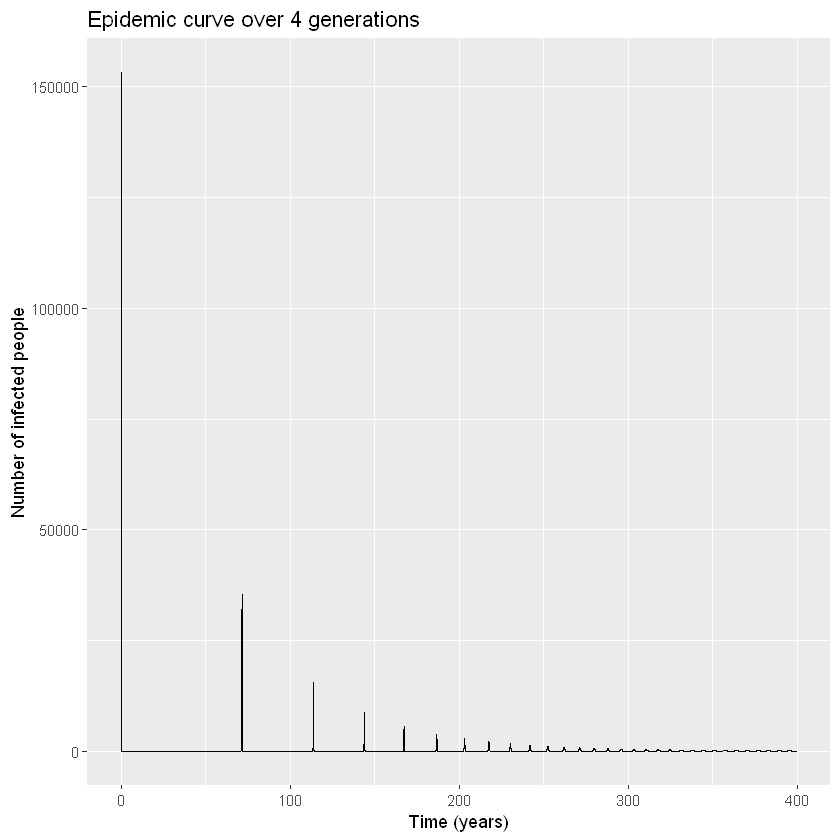

In [2]:
output_long <- melt(as.data.frame(output), id = "time")                  # turn output dataset into long format

# Plot of the epidemic curve over time
ggplot(data = output,                                               
       aes(x = time, y = I)) +                                           # only plotting the I column from our output
  geom_line() +                                                          # represent data as lines
  xlab("Time (years)")+                                                  # add label for x axis
  ylab("Number of infected people") +                                    # add label for y axis
  labs(title = "Epidemic curve over 4 generations")                      # add plot title   

### What do you observe about the long-term disease dynamics under these assumptions? Can you explain why this pattern occurs based on what you have learnt in the last weeks?

Over several generations, we see that the number of infected people oscillates over time. These are sharp epidemic cycles: epidemics reoccur repeatedly over time, although the peaks become progressively smaller and eventually disappear. The first peak is the one we looked at above.

This pattern occurs because the disease has a much shorter duration than the human population turnover. Once an epidemic has spread through the population and depleted the susceptible pool, it takes a long time for the susceptibles to replenish through births. This is why we see these deep and long troughs (around 70 years until the second epidemic) between epidemics. 

We can confirm this by adding susceptible and recovered people to the plot below. As you can see, there are consecutive peaks and troughs in the number of susceptible and immune people as well, with the number in the immune compartment being at its lowest when the number of susceptibles peaks. 

Once the proportion of susceptibles is sufficiently high for infection to spread, the number of infected people starts rising. Just before the peak of the epidemic, more susceptibles are removed through infection than are added through births, so the susceptible proportion starts going into decline again. As you should remember from last week, the epidemic peaks when the effective reproduction number equals 1 - and in the simple SIR model, the effective reproduction number is directly proportional to the proportion of susceptibles through the formula: 

\begin{align}
R_{eff} = R_{0} \frac{S}{N}
\end{align}

By rearranging the equation, we see that the epidemic peaks when the proportion of susceptibles $S/N = 1/R_{0}$. In our example R<sub>0</sub> = 0.4/0.2 = 2. Indeed, we can see that the peaks in the number of infectious people occur when the proportion susceptible equals 0.5. After that, the proportion of susceptibles becomes too low for each infectious person to cause at least one secondary case on average - the prevalence of infection decreases and the epidemic ends, until the pool of susceptibles is replenished again.

If you were to plot Reff, you would see it follows the same pattern as the proportion in the susceptible compartment.

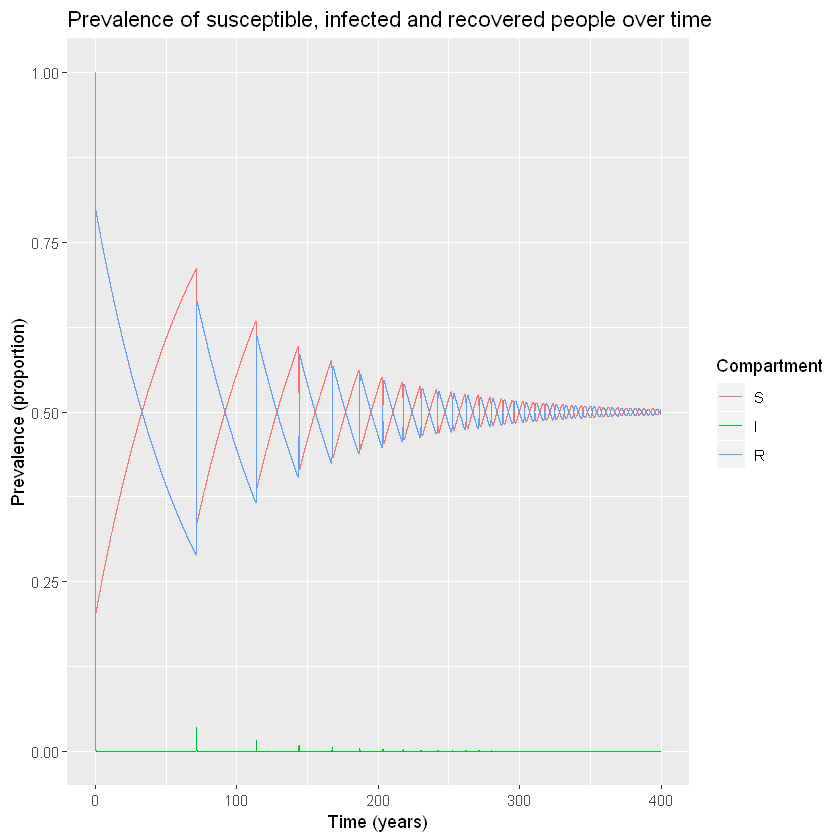

In [3]:
output_long <- melt(as.data.frame(output), id = "time")                  # turn output dataset into long format

# Calculating the proportion in each compartment as a column in the long-format output
output_long$proportion <- output_long$value/sum(initial_state_values)

# Plot the number of people in the S, I and R compartments over time
ggplot(data = output_long,                                               # specify object containing data to plot
       aes(x = time, y = proportion, colour = variable, group = variable)) +  # assign columns to axes and groups
  geom_line() +                                                          # represent data as lines
  xlab("Time (years)")+                                                  # add label for x axis
  ylab("Prevalence (proportion)") +                                      # add label for y axis
  labs(colour = "Compartment",                                           # add legend title  
       title = "Prevalence of susceptible, infected and recovered people over time")

In the second example, we are modelling a similar acute disease, but this time in a population with much faster turnover. The infection parameters are the same as before, but we are assuming the average lifespan is 4 weeks.

**Modelling this population over 1 year:**

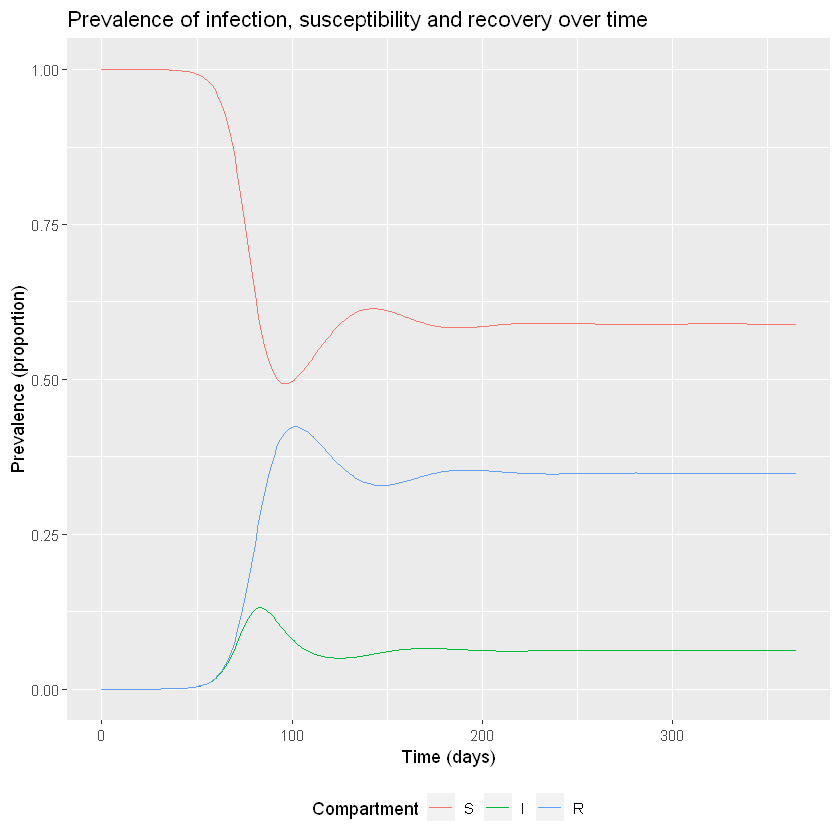

In [4]:
# LOAD THE PACKAGES:
library(deSolve)
library(reshape2)
library(ggplot2)

# MODEL INPUTS:

# Vector storing the initial number of people in each compartment (at timestep 0)
initial_state_values <- c(S = 1000000-1,   # the whole population we are modelling is susceptible to infection
                          I = 1,           # the epidemic starts with a single infected person
                          R = 0)           # there is no prior immunity in the population

# Vector storing the parameters describing the transition rates in units of days^-1
parameters <- c(beta = 0.4,      # the infection rate, which acts on susceptibles
                gamma = 0.2,     # the rate of recovery, which acts on those infected
                mu = 1/28,       # the mortality rate, which acts on each compartment
                b = 1/28)        # the birth rate

# TIMESTEPS:

# Vector storing the sequence of timesteps to solve the model at
times <- seq(from = 0, to = 365, by = 1)   # from 0 to 365 days in daily intervals

# SIR MODEL FUNCTION: 

# The model function takes as input arguments (in the following order): time, state and parameters
sir_model <- function(time, state, parameters) {  

    with(as.list(c(state, parameters)), {  # tell R to look for variable names within the state and parameters objects    
        
    # Calculating the total population size N (the sum of the number of people in each compartment)
      N <- S+I+R
      
    # Defining lambda as a function of beta and I:
      lambda <- beta * I/N
        
    # The differential equations
      dS <- -lambda * S - mu * S + b * N            
      dI <- lambda * S - gamma * I  - mu * I           
      dR <- gamma * I - mu * R               
      
    # Return the number of people in the S, I and R compartments at each timestep 
    # (in the same order as the input state variables)
    return(list(c(dS, dI, dR))) 
    })
  
}

# MODEL OUTPUT (solving the differential equations):

# Solving the differential equations using the ode integration algorithm
output_pigs <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters))

# PLOT

output_pigs_long <- melt(as.data.frame(output_pigs), id = "time")        # turn output dataset into long format

# Adding a column for the prevalence proportion to the long-format output
output_pigs_long$prevalence <- output_pigs_long$value/sum(initial_state_values)

# Plot the prevalence proportion
ggplot(data = output_pigs_long,                                               # specify object containing data to plot
       aes(x = time, y = prevalence, colour = variable, group = variable)) +  # assign columns to axes and groups
  geom_line() +                                                          # represent data as lines
  xlab("Time (days)")+                                                   # add label for x axis
  ylab("Prevalence (proportion)") +                                      # add label for y axis
  labs(colour = "Compartment",                                           # add legend title
       title = "Prevalence of infection, susceptibility and recovery over time") +  # add plot title
  theme(legend.position = "bottom")

### How do the disease dynamics compare to the previous example? Why does this occur (what is different compared to the disease in the human population)?

In the rapid-turnover population, we don't observe epidemic cycles like in the slow-turnover example. Instead, an epidemic occurs after about 80 days of introduction of an infectious case. After the peak, the prevalence of infection starts to decline - but this time not to 0! After the epidemic, the prevalence of susceptibles, infected and recovered people reaches a stable equilibrium, where around 6% remain infected. When the system is in equilibrium, we refer to this as **endemicity**. As opposed to an epidemic, an endemic infection does not die out but remains stable within a population. 

In this example, an acute disease with the same infection parameters becomes endemic in the pig population because the population turnover is much faster compared to humans. The susceptible pool is replenished quickly through new births, so infectious individuals can cause at least 1 secondary case on average throughout. You should see that the proportion susceptible remains stable at a value > 0.5.  

In the plot below, you can see how this corresponds to the effective reproduction number:

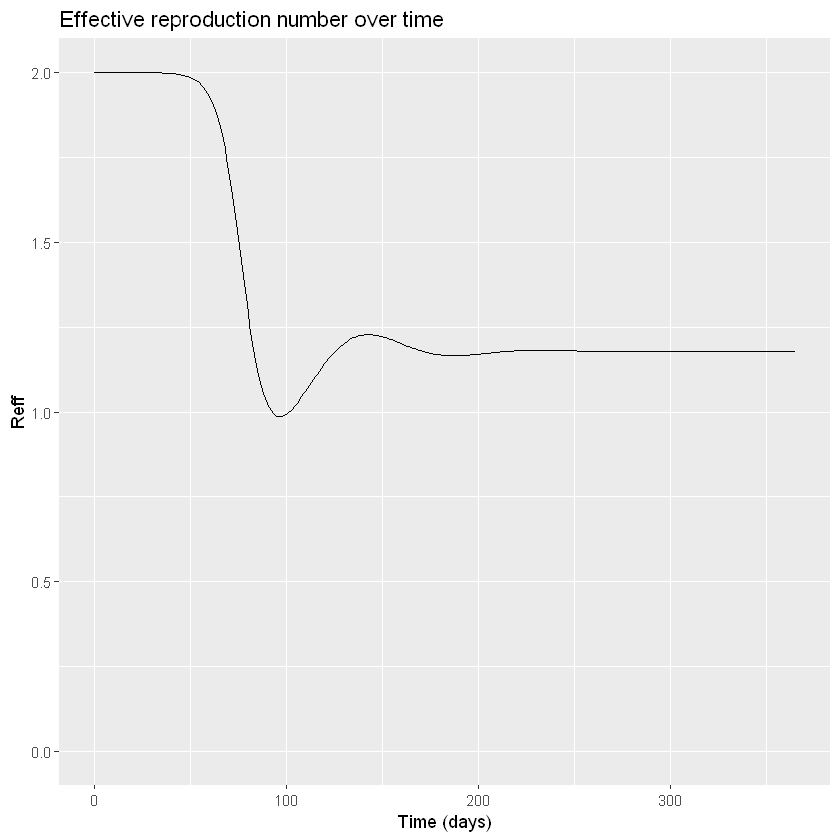

In [5]:
# Calculating the effective reproduction number 
output_pigs$reff <- parameters["beta"]/parameters["gamma"] *                    # R0 = beta/gamma
                      output_pigs$S/(output_pigs$S+output_pigs$I+output_pigs$R) # multiply R0 by the proportion susceptible
                                                                                # at each timestep/for each row

# Plot Reff
ggplot(data = output_pigs,                                               # specify object containing data to plot
       aes(x = time, y = reff)) +                                        # assign columns to axes and groups
  geom_line() +                                                          # represent data as lines
  xlab("Time (days)")+                                                   # add label for x axis
  ylab("Reff") +                                                         # add label for y axis
  labs(title = "Effective reproduction number over time") +              # add plot title
  ylim(c(0,2))

## Additional questions

### Other drivers for epidemic cycles

Several other factors could drive an oscillating pattern in infection dynamics, for example:  
- seasonal transmission, if the epidemics always occur around the same time each year (e.g. measles transmission during the school term, flu transmission in winter)  
- environmental drivers are another very important cause for epidemic cycles, for example with humidity playing an important role in influenza transmission
- stochastic effects 

### Modelling a growing population

For the population to grow, the birth rate needs to be higher than the mortality rate. Another factor affecting the population size could be migration.

### Modelling a disease where a proportion *p* of babies born to infected mothers are infected at birth

To model mother-to-child transmission, we need to capture two aspects:  
1) infected mothers can infect a proportion *p* of their newborns  
2) babies born to uninfected mothers, and a proportion 1-p of babies born to infected mothers, are born into the susceptible compartment  
 

We can define the number of babies infected at birth as:
\begin{align}
births_{i} = p b I 
\end{align}
We can define the number of babies born susceptible as:
\begin{align}
births_{u} = (1-p) b I + b S + b R
\end{align}

Adding this into the differential equations:

\begin{align}
\frac{dS}{dt} & = -\beta \frac{I}{N} S - \mu S + births_{u} \\
\frac{dI}{dt} & = \beta \frac{I}{N} S - \gamma I - \mu I  + births_{i}\\
\frac{dR}{dt} & = \gamma I - \mu R
\end{align}
